In [2]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1

     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 421.8MB 19kB/s 
     |████████████████████████████████| 3.9MB 42.4MB/s 
     |████████████████████████████████| 450kB 42.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=e2614dcc2443c5fcb5f3de9eb691257e018194945f76ce96e82689e026b13b25
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [90]:
#For live loss function updates
#!pip install livelossplot

In [91]:
%matplotlib inline

In [92]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold


In [94]:
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)


In [95]:
#print(os.listdir("membrane/train"))

#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128
splits = KFold(n_splits=6,shuffle=True,random_state=42)
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("images-1024x768\images"):
    print("Seee")
    print(directory_path)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images, dtype='float32')

#Capture mask/label info as a list
train_masks = [] 
print("Nothing???")
for directory_path in glob.glob("images-1024x768/masks"):
    print("Hereeee")
    print(directory_path)
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks,  dtype='float32')


Seee
images-1024x768\images
Nothing???
Hereeee
images-1024x768/masks


In [96]:
train_images.dtype

dtype('float32')

In [97]:
train_masks.dtype

dtype('float32')

In [184]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.18, random_state=1) # 0.25 x 0.8 = 0.2.. 0.2 * 0.85 = 

# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)
x_val = preprocess_input(x_val)

# print(x_train)

In [185]:
# define model
sm.set_framework('tf.keras')
sm.framework()

# with pre-trained backbones and encoder weights from imagenet

model = sm.Unet(BACKBONE, encoder_weights='imagenet', activation='sigmoid')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

print(model.summary())


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_8[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                        

In [186]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
#from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training (callbacks=[PlotLossesKeras()],)
# print(model)
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)


x_test = tf.cast(x_test, tf.float32)
y_test = tf.cast(y_test, tf.float32)


# k - fold cross validation see

dataset = ConcatDataset([x_train, x_test])

k=6
splits=KFold(n_splits=k,shuffle=True,random_state=42)

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=32, sampler=test_sampler)


print(train_sampler)
print(train_loader)
# for i, j in train_loader:
#    print("I is ", i, " J is ", j)

print("check again")
x_val = tf.cast(x_val, tf.float32)
y_val = tf.cast(y_val, tf.float32)

model.fit(
   x=x_train,
   y=y_train,
   batch_size=2,
   epochs=5,
   verbose=1,
   validation_data=(x_val, y_val),
)
print("should work now")
accuracy = model.evaluate(x_test, y_test)
# possibly something to do here with validation data 
print('accuracy is ', accuracy)


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
check again
Epoch 1/5
16/16 [==============================] - 24s 1s/step - loss: -40.9174 - iou_score: 1.8111 - val_loss: -4245.5293 - val_iou_score: 61.6747
Epoch 2/5
16/16 [==============================] - 17s 1s/step - loss: -190.0325 - iou_score: 6.0484 - val_loss: -3001.0864 - val_iou_score: 62.2472
Epoch 3/5
16/16 [==============================] - 18s 1s/step - loss: -300.8780 - iou_score: 12.3497 - val_loss: -2392.6357 - val_iou_score: 63.9807
Epoch 4/5
16/16 [==============================] - 17s 1s/step - loss: -444.3289 - iou_score: 18.5212 - val_loss: -1885.3167 - val_iou_score: 67.0505
Epoch 5/5
16/16 [==============================] - 17s 1s/step - loss: -596.9023 - iou_score: 17.8867 - val_loss: -2352.3555 - val_iou_score: 65.4859
should work now
1/1 [==============================] - 7s 7s/step - loss: -2417.9014 - iou_score: 65.3974
accuracy is  [-2417.9013671875, 65.3973617553711]


In [187]:
model.save('/data/membrane3000.h5')

In [188]:
from tensorflow import keras
model = keras.models.load_model('/data/membrane3000.h5', compile=False)

[[[ 46  63  72]
  [ 43  62  70]
  [ 39  56  65]
  ...
  [ 86 101 117]
  [ 83  99 115]
  [ 86 101 117]]

 [[ 51  68  77]
  [ 45  64  72]
  [ 44  59  68]
  ...
  [ 85 100 116]
  [ 81  97 113]
  [ 88 103 119]]

 [[ 45  62  71]
  [ 41  58  67]
  [ 38  55  64]
  ...
  [ 84  99 115]
  [ 84  99 115]
  [ 81  96 112]]

 ...

 [[ 83  98 107]
  [ 82  97 106]
  [ 83  99 106]
  ...
  [116 132 144]
  [119 137 148]
  [119 135 147]]

 [[ 83  98 107]
  [ 83  98 107]
  [ 85 100 109]
  ...
  [114 132 143]
  [118 136 147]
  [118 136 147]]

 [[ 86 102 109]
  [ 87 102 111]
  [ 83  98 107]
  ...
  [116 133 142]
  [119 138 146]
  [117 134 143]]]


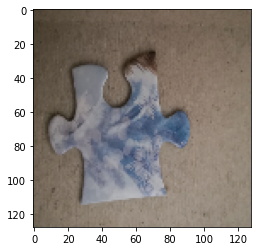

In [189]:
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('images_prepped_val/image-26.png', cv2.IMREAD_COLOR)      
print(test_img)
plt.imshow(test_img)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

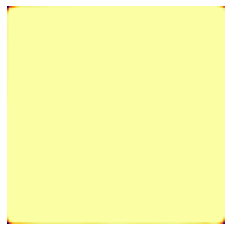

In [190]:
#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='inferno')
plt.axis("off")

plt.show()
#plt.imsave('images/test_images/segmented.jpg', prediction_image, cmap='gray')


In [191]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, _ = roc_curve(ground_truth_labels,score_value)
print(fpr, tpr)
roc_auc = auc(fpr,tpr)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan] [0.00000000e+00 4.65029762e-07 4.18526786e-06 1.34858631e-05
 3.11569940e-05 5.85937500e-05 9.85863095e-05 1.4

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


In [181]:
y_score1 = clf_tree.predict_proba(X_test)[:,1]
y_score2 = clf_reg.predict_proba(X_test)[:,1]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)

nan